# Vision Transformer vs EfficientNet for facial image classification based on gender

In [1]:
import os
import re
import warnings
from abc import abstractmethod
from pathlib import Path

import pytorch_hyperlight as pth
import pytorch_lightning as pl
import pytorch_pretrained_vit
import torch
from efficientnet_pytorch import EfficientNet
from PIL import Image
from pytorch_hyperlight.tasks.classification import AClassificationTask

# from transformers import AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torch.nn.functional as F

In [2]:
USAGE_MODE_LIST = [
    "single-run",
    "hyper-opt",
]  # choose from 'single-run' and 'hyper-opt'
# USAGE_MODE_LIST = ["hyper-opt"]
# USAGE_MODE_LIST = ["single-run"]
FAST_DEV_RUN = False  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

In [3]:
if "workbookDir" not in globals():
    workbookDir = os.getcwd()

WORKBOOK_DIR = Path(workbookDir)

In [4]:
# !kaggle datasets download -d 'nipunarora8/age-gender-and-ethnicity-face-data-csv'
# !unzip -n age-gender-and-ethnicity-face-data-csv.zip

In [5]:
!kaggle datasets download -d 'jangedoo/utkface-new'

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip -n -q utkface-new.zip

In [7]:
class UTKFaces(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self._file_list = file_list
        self._labels = labels
        self.transform = transform

    def __len__(self):
        return len(self._file_list)

    def __getitem__(self, idx):
        img_path = self._file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        id_label = int(self._labels[idx])

        return img_transformed, id_label

In [8]:
EXPERIMENT_ID = "vit-utk-faces"

In [9]:
DATASETS_PATH = WORKBOOK_DIR / "UTKFace"

In [10]:
SEED = 16

In [11]:
IMAGE_SIZE = 200

In [12]:
warnings.filterwarnings("ignore")

In [13]:
all_names = list(DATASETS_PATH.glob("*.jpg"))

age_list, gender_list, etnicity_list = zip(
    *[re.split("_", cur_file.name, maxsplit=3)[:3] for cur_file in all_names]
)

In [14]:
# a dedicated function for creating datasets
# please note how 'full_train_dataset' is created along with train,
# val and test datasets
def create_datasets(val_size=0.2, test_size=0.05):
    pl.seed_everything(SEED)
    all_names = list(DATASETS_PATH.glob("*.jpg"))
    age_list, gender_list, etnicity_list = zip(
        *[re.split("_", cur_file.name, maxsplit=3)[:3] for cur_file in all_names]
    )
    TRANSFORMS = transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
    #
    labels = gender_list

    n_classes = len(set(labels))
    full_train_dataset = UTKFaces(all_names, labels, transform=TRANSFORMS)

    n_full_train_samples = len(full_train_dataset)
    n_val_samples = int(n_full_train_samples * val_size)
    n_test_samples = int(n_full_train_samples * test_size)
    train_dataset, val_dataset, test_dataset = random_split(
        full_train_dataset,
        [
            n_full_train_samples - n_val_samples - n_test_samples,
            n_val_samples,
            n_test_samples,
        ],
    )

    return {
        "full_train_dataset": train_dataset + val_dataset,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
        "n_classes": n_classes,
    }

In [15]:
# a dedicated function for creating dataloaders
# 'full_train_loader' is created along with standard 3 loaderers
# for training, validation and testing datasets
def configure_dataloaders(batch_size, n_workers=4):
    #
    SHUFFLE = True
    SAMPLER = None
    #
    result_dict = create_datasets()
    #
    for prefix in ["train", "full_train"]:

        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=SHUFFLE,
            sampler=SAMPLER,
            num_workers=n_workers,
            pin_memory=True,
        )
    #
    for prefix in ["val", "test"]:
        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=n_workers,
            pin_memory=True,
        )

    return result_dict

Let us make sure our dataloaders can be created correctly

In [16]:
BATCH_SIZE = 32

loaders_dict = configure_dataloaders(BATCH_SIZE)

loaders_dict

batch = next(iter(loaders_dict["test_loader"]))
assert len(batch[0]) > 0

Global seed set to 16


In [17]:
result_dict = create_datasets()
{f"len({k})": len(v) for k, v in result_dict.items() if isinstance(v, Dataset)}

Global seed set to 16


{'len(full_train_dataset)': 22523,
 'len(train_dataset)': 17782,
 'len(val_dataset)': 4741,
 'len(test_dataset)': 1185}

In [18]:
loaders_dict["n_classes"]

2

In [19]:
class FCClassifier(nn.Module):
    def __init__(self, n_features, n_classes, dropout):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.classifier0 = nn.Linear(n_features, n_features)
        self.classifier1 = nn.Linear(n_features, n_classes)
        #
        self.classifier0.weight.data.normal_(mean=0.0, std=0.02)
        self.classifier0.bias.data.zero_()
        self.classifier1.weight.data.normal_(mean=0.0, std=0.02)
        self.classifier1.bias.data.zero_()

    def forward(self, pooled_output):

        pooled_output = self.classifier0(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier1(pooled_output)
        return logits

In [20]:
class AFineTunedClassifier(AClassificationTask):
    def __init__(self, hparams, model):
        criterion = nn.CrossEntropyLoss()
        super().__init__(hparams, model, criterion)

    @abstractmethod
    def _get_fc_param_names(self):
        pass

    def configure_optimizers(self):
        fc_param_name_list = self._get_fc_param_names()
        fc_param_list = [
            param
            for name, param in self.model.named_parameters()
            if name in fc_param_name_list
        ]
        rest_param_list = [
            param
            for name, param in self.model.named_parameters()
            if name not in fc_param_name_list
        ]
        """
        warmup = self.hparams.warmup
        optimizer = AdamW(
            [
                {"params": fc_param_list, "lr": self.hparams.fc_lr},
                {"params": rest_param_list, "lr": self.hparams.rest_lr},
            ]
        )

        scheduler = get_linear_schedule_with_warmup(
            optimizer, warmup, self.hparams.n_train_steps
        )
        return [optimizer], [
            {"scheduler": scheduler, "interval": "step", "frequency": 1}
        ]
        """
        optimizer = optim.Adam(
            [
                {"params": fc_param_list, "lr": self.hparams.fc_lr},
                {"params": rest_param_list, "lr": self.hparams.rest_lr},
            ]
        )
        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.hparams.step_lr_step_size,
            gamma=self.hparams.step_lr_gamma,
        )
        return [optimizer], [scheduler]

    def _build_fc(self, hparams, n_features):
        n_classes = hparams["n_classes"]
        fc_dropout = hparams["fc_dropout"]
        fc_dropout = hparams["fc_dropout"]
        fc = FCClassifier(n_features, n_classes, fc_dropout)
        return fc

In [21]:
class ViTClassifier(AFineTunedClassifier):
    def __init__(self, hparams):
        model_name = hparams["model_name"]
        model = pytorch_pretrained_vit.ViT(
            model_name, image_size=IMAGE_SIZE, pretrained=True
        )
        model.fc = self._build_fc(hparams, model.fc.in_features)
        super().__init__(hparams, model)

    def _get_fc_param_names(self):
        return ["fc.weight", "fc.bias"]

In [22]:
class EfficientNetClassifier(AFineTunedClassifier):
    def __init__(self, hparams):
        model_name = hparams["model_name"]
        model = EfficientNet.from_pretrained(model_name)
        model._fc = self._build_fc(hparams, model._fc.in_features)
        super().__init__(hparams, model)

    def _get_fc_param_names(self):
        return ["_fc.weight", "_fc.bias"]

In [23]:
N_CLASSES = loaders_dict["n_classes"]
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

In [24]:
CONFIG = {
    # "fc_lr": 3e-3,
    # "rest_lr": 2e-5,
    "fc_lr": 1e-3,
    "rest_lr": 1e-5,
    "step_lr_gamma": 0.6,
    "step_lr_step_size": 1,
    "fc_dropout": 0.2,
    # "warmup": 500,  # For LinearSchedulerWihtWarmup
    "gradient_clip_val": 2,
    "max_epochs": 10,  # the actual number can be less due to early stopping
    "batch_size": 20,
    "n_classes": N_CLASSES,
}

TUNE_CONFIG = {
    "seed": SEED,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 0,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 3,  # for PTL Trainer
    "ptl_precision": 16,  # or 16, for PTL Trainer
    "train_loader_name": "train_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2

In [25]:
runner = pth.Runner(
    configure_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Loaded pretrained weights for efficientnet-b7


Global seed set to 16

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | EfficientNet     | 70.3 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
70.3 M    Trainable params
0         Non-trainable params
70.3 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

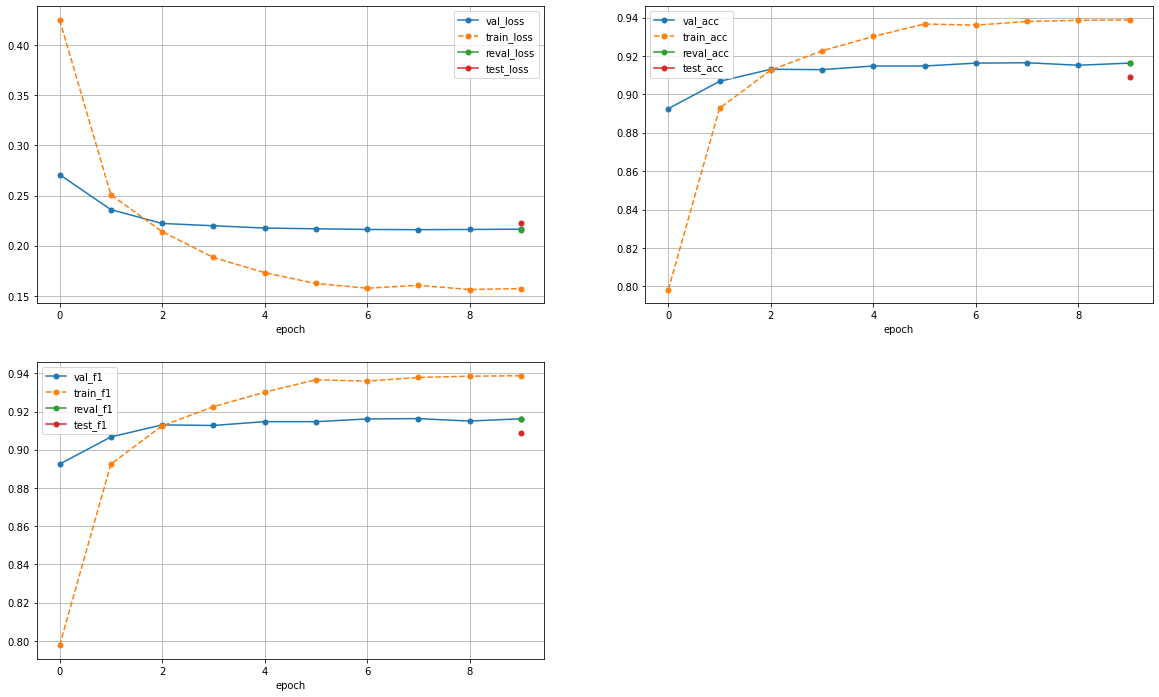

Loaded pretrained weights for efficientnet-b7


Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [26]:
if "single-run" in USAGE_MODE_LIST:
    config = CONFIG.copy()
    config["model_name"] = "efficientnet-b7"
    config["gradient_clip_val"] = 0
    best_result = runner.run_single_trial(
        EfficientNetClassifier, config, TUNE_CONFIG, extra_run_name_prefix="noclip-"
    )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Loaded pretrained weights for efficientnet-b7


Global seed set to 16

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | EfficientNet     | 70.3 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
70.3 M    Trainable params
0         Non-trainable params
70.3 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

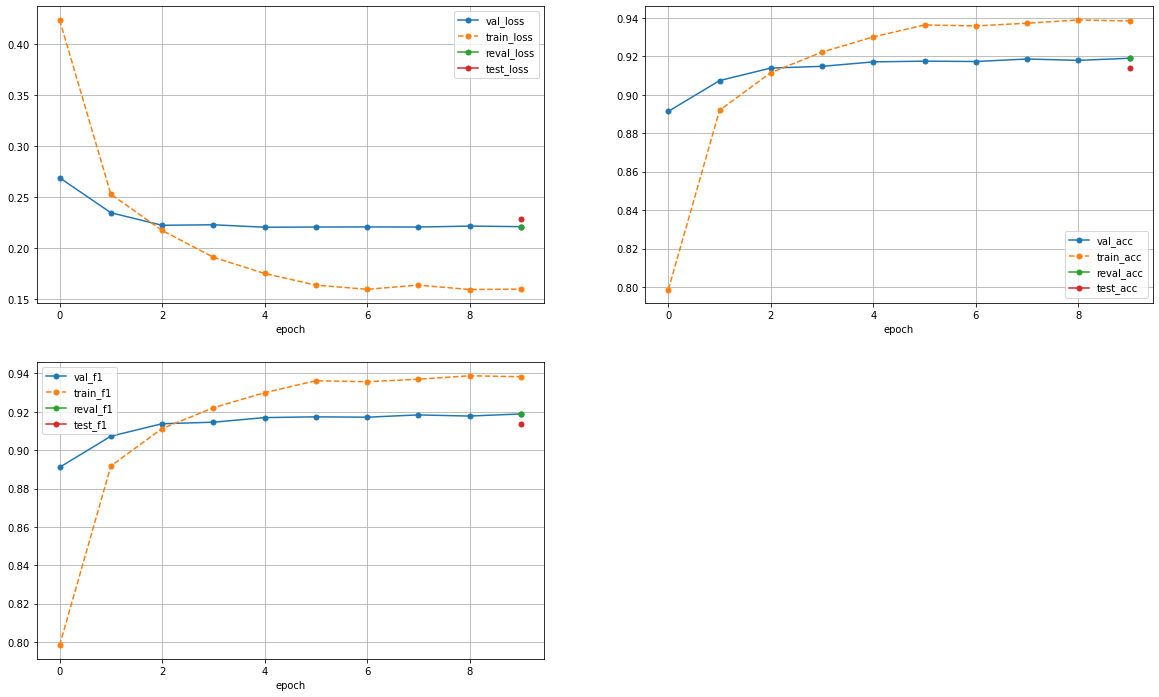

Loaded pretrained weights for efficientnet-b7


Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [27]:
if "single-run" in USAGE_MODE_LIST:
    config = CONFIG.copy()
    config["model_name"] = "efficientnet-b7"
    config["gradient_clip_val"] = 2
    best_result = runner.run_single_trial(
        EfficientNetClassifier, config, TUNE_CONFIG, extra_run_name_prefix="clip-"
    )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])


Global seed set to 16


Loaded pretrained weights.



  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | ViT              | 86.4 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
86.4 M    Trainable params
0         Non-trainable params
86.4 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

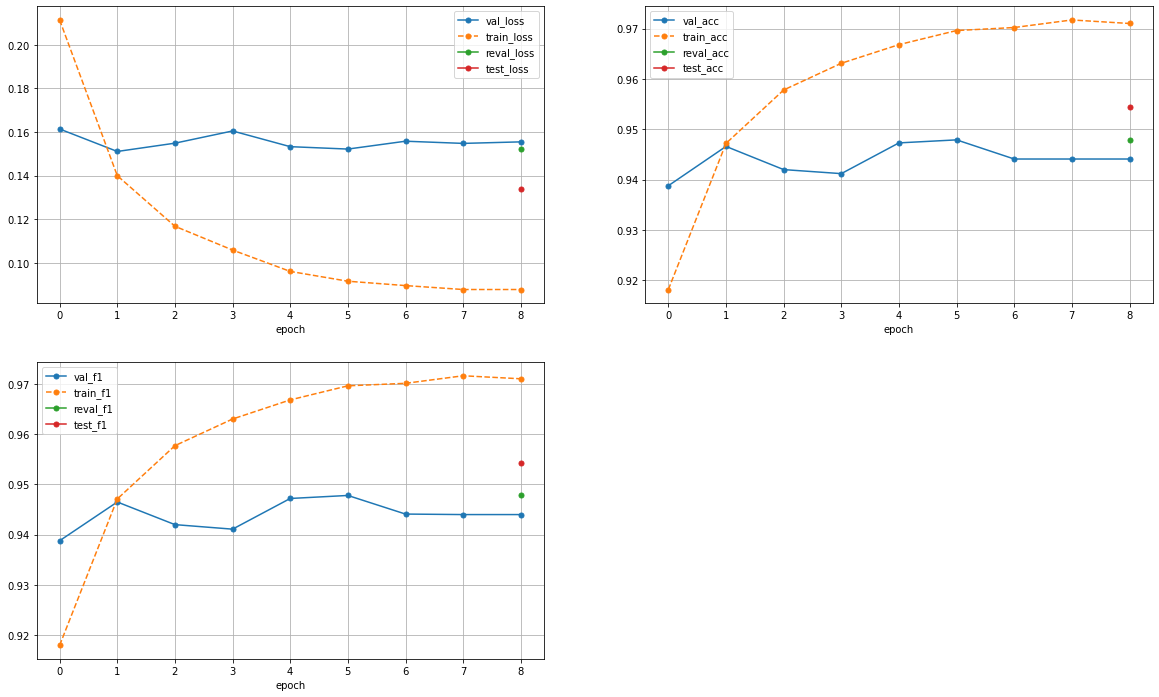

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])
Loaded pretrained weights.


Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [28]:
if "single-run" in USAGE_MODE_LIST:
    config = CONFIG.copy()
    config["model_name"] = "B_16_imagenet1k"
    config["gradient_clip_val"] = 0
    best_result = runner.run_single_trial(
        ViTClassifier, config, TUNE_CONFIG, extra_run_name_prefix="noclip-"
    )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])


Global seed set to 16


Loaded pretrained weights.



  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | ViT              | 86.4 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
86.4 M    Trainable params
0         Non-trainable params
86.4 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

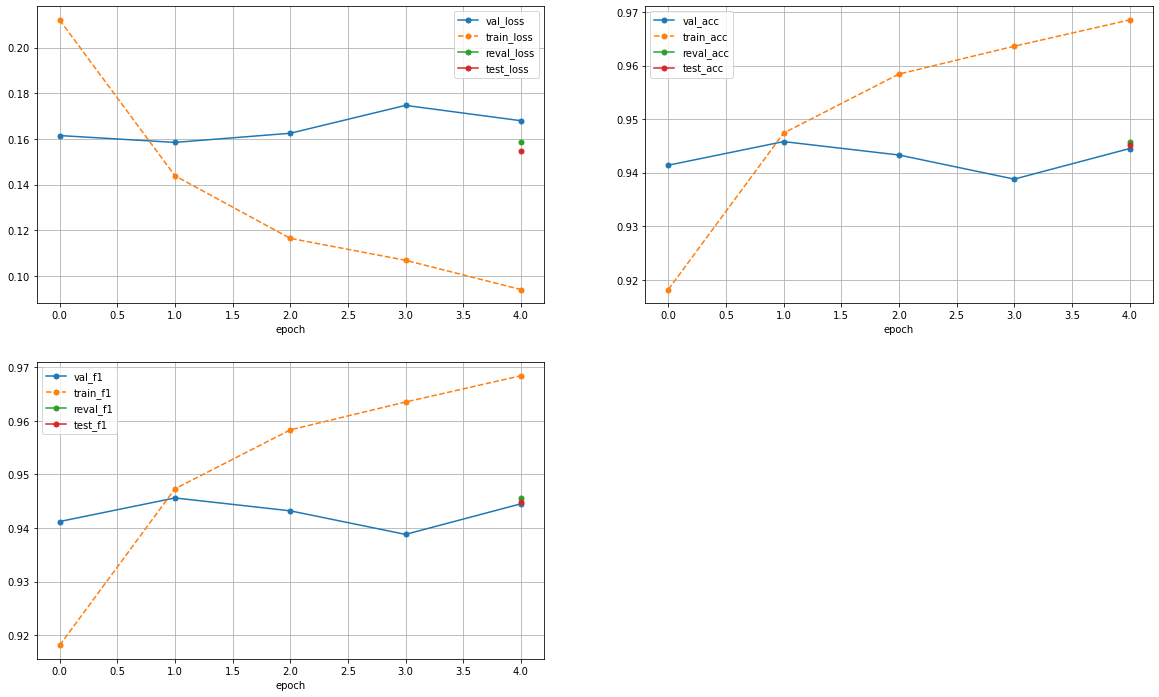

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])
Loaded pretrained weights.


Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [29]:
if "single-run" in USAGE_MODE_LIST:
    config = CONFIG.copy()
    config["model_name"] = "B_16_imagenet1k"
    config["gradient_clip_val"] = 2
    best_result = runner.run_single_trial(
        ViTClassifier, config, TUNE_CONFIG, extra_run_name_prefix="clip-"
    )

,test_f1,test_acc,run
10,0.9543,0.9544,noclip-single-trial-ViTClassifier
6,0.9449,0.9451,clip-single-trial-ViTClassifier
11,0.9138,0.9139,clip-single-trial-EfficientNetClassifier
11,0.9087,0.9089,noclip-single-trial-EfficientNetClassifier


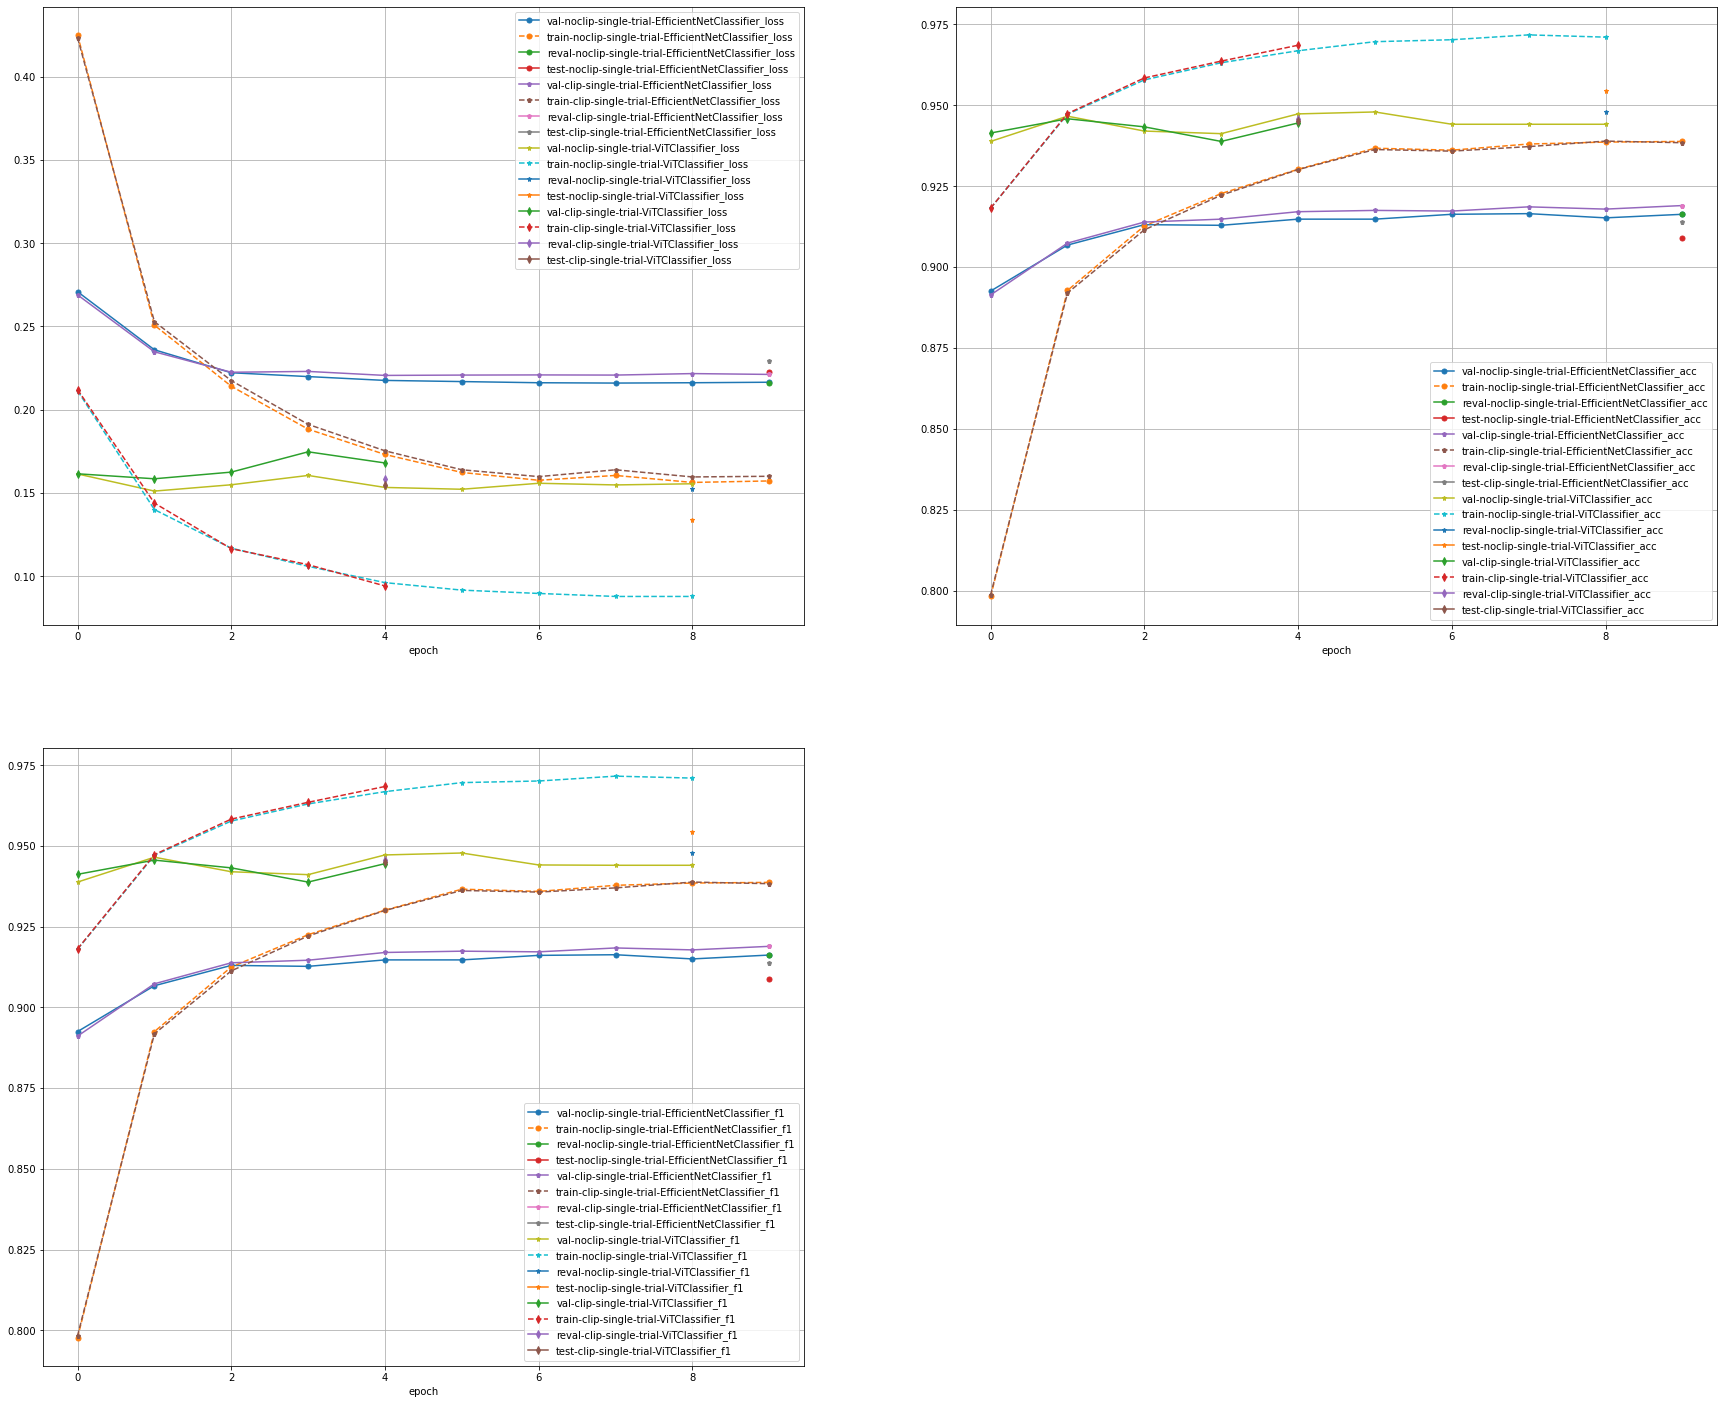

In [30]:
runner.show_metric_report(sort_by_metric_list=["test_f1", "test_acc"], figsize=(30, 25))